<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" height=100 width=300 />


# League of Legends Match Outcome Predictor — PyTorch Logistic Regression

**Short description:**  
This notebook trains and evaluates a logistic regression classifier (implemented in PyTorch) to predict match outcomes (win/loss) from match-level features in a League of Legends dataset. It includes data loading and preprocessing, model implementation, training, optimization, evaluation, visualization, model saving and loading, hyperparameter tuning, and feature importance analysis.

**Context:**
League of Legends, a popular multiplayer online battle arena (MOBA) game, generates extensive data from matches, providing an excellent opportunity to apply machine learning techniques to real-world scenarios. Perform the following steps to build a logistic regression model aimed at predicting the outcomes of League of Legends matches.

Download the dataset: [league_of_legends_data_large.csv](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rk7VDaPjMp1h5VXS-cUyMg/league-of-legends-data-large.csv)

**Objectives**
- Load and preprocess the League of Legends dataset (train/test split, scaling).
- Build a simple logistic regression model using PyTorch `nn.Module`.
- Train baseline and L2-regularized models, evaluate on train/test sets.
- Visualize confusion matrices, ROC curves and print classification reports.
- Perform a small hyperparameter search for learning rate and evaluate final model.
- Extract and visualize feature importances from the learned linear weights.

**Notice about documentation:**  
The original notebook submission (course assignment) was kept intact. I have **only modified documentation (comments, headings, markdown)** and made **minimal, necessary corrections** to ensure the notebook runs without errors. All rights related to the lab/workshop design and original exercise belong exclusively to **IBM Corporation**. This notebook includes additional documentation for clarity, but the intellectual property of the original exercise is retained by IBM.

---

## Table of contents

1. Dependencies & execution instructions  
2. Data loading & preprocessing  
3. Model definition (PyTorch logistic regression)  
4. Training baseline model  
5. L2-regularized model training  
6. Evaluation: confusion matrices, classification reports, ROC curves  
7. Model saving/loading and re-evaluation  
8. Learning-rate sweep and selection  
9. Feature importance extraction & plotting  
10. Notes & reproducibility


## 1) Dependencies & execution instructions

This section installs and imports required Python packages.  

**Recommended local execution steps:**

1. Create and activate a Python virtual environment:
   - `python -m venv venv`
   - `source venv/bin/activate` (macOS / Linux) or `venv\Scripts\activate` (Windows)
2. Install dependencies:
   - `pip install -r requirements.txt`
3. Launch Jupyter Notebook:
   - `jupyter notebook`
4. Open this notebook and run cells top-to-bottom.

**Note:** If you plan to train on GPU, ensure PyTorch with CUDA is installed.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools

## 2) Data loading & preprocessing

Load `league_of_legends_data_large.csv` into a DataFrame, separate features and label (`win`), split into train and test sets with stratification, apply `StandardScaler`, and convert to PyTorch tensors.


In [2]:

 
lol_df = pd.read_csv("league_of_legends_data_large.csv")
X = lol_df.drop(["win"], axis = 1)
y = lol_df["win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

## 3) Model definition

Define a simple logistic regression model as a PyTorch `nn.Module` with a single linear layer and a forward pass using sigmoid activation for binary classification. Use `BCELoss` as the criterion and `SGD` as the optimizer.

In [3]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = torch.sigmoid(self.linear(x))
        return x

model = LogisticRegressionModel(input_dim = X_train.shape[1], output_dim = 1)
criterion = torch.nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

## 4) Training baseline model

Train the baseline logistic regression for `epochs = 1000`, printing the loss every 100 epochs. After training, evaluate train and test accuracy.

In [4]:
epochs = 1000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"epoch: {epoch}, loss: {loss.item()}")

model.eval()
with torch.no_grad():
    train_outputs = model(X_train)
    test_outputs = model(X_test)

    train_preds = (train_outputs >= 0.5).float()
    test_preds = (test_outputs >= 0.5).float()

    y_train_reshaped = y_train.view(-1, 1)
    y_test_reshaped = y_test.view(-1, 1)

    train_accuracy = (train_preds.eq(y_train_reshaped).sum().item()) / y_train_reshaped.size(0)
    test_accuracy = (test_preds.eq(y_test_reshaped).sum().item()) / y_test_reshaped.size(0)

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

epoch: 0, loss: 0.753054678440094
epoch: 100, loss: 0.7295802235603333
epoch: 200, loss: 0.7145402431488037
epoch: 300, loss: 0.7051444053649902
epoch: 400, loss: 0.6993623971939087
epoch: 500, loss: 0.6958318948745728
epoch: 600, loss: 0.6936825513839722
epoch: 700, loss: 0.6923741698265076
epoch: 800, loss: 0.691576361656189
epoch: 900, loss: 0.6910885572433472
Training Accuracy: 0.5300
Test Accuracy: 0.5300


## 5) L2-regularized model training

Train a second logistic regression model with L2 regularization (using `weight_decay` in the optimizer) and evaluate accuracy for comparison.

**L2 Optimization technique:**

Optimization techniques such as L2 regularization (Ridge Regression) help in preventing overfitting. The model is retrained with these optimizations, and its performance is evaluated on both training and testing sets. 

**Weight Decay:** 

In the context of machine learning and specifically in optimization algorithms, weight_decay is a parameter used to apply L2 regularization to the model's parameters (weights). It helps prevent the model from overfitting by penalizing large weight values, thereby encouraging the model to find simpler solutions.To use L2 regularization, you need to modify the optimizer by setting the weight_decay parameter. The weight_decay parameter in the optimizer adds the L2 regularization term during training.

In [5]:
model_l2 = LogisticRegressionModel(input_dim = X_train.shape[1], output_dim = 1)
optimizer_l2 = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

epochs = 1000

for epoch in range(epochs):
    model_l2.train()
    optimizer_l2.zero_grad()
    outputs = model_l2(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    loss.backward()
    optimizer_l2.step()

    if epoch % 100 == 0:
        print(f"epoch: {epoch}, loss: {loss.item()}")

model_l2.eval()
with torch.no_grad():
    train_outputs_l2 = model_l2(X_train)
    test_outputs_l2 = model_l2(X_test)

    train_preds_l2 = (train_outputs_l2 >= 0.5).float()
    test_preds_l2 = (test_outputs_l2 >= 0.5).float()

    y_train_reshaped = y_train.view(-1, 1)
    y_test_reshaped = y_test.view(-1, 1)

    train_accuracy_l2 = (train_preds_l2.eq(y_train_reshaped).sum().item()) / y_train_reshaped.size(0)
    test_accuracy_l2 = (test_preds_l2.eq(y_test_reshaped).sum().item()) / y_test_reshaped.size(0)

    print(f"Training Accuracy: {train_accuracy_l2:.4f}")
    print(f"Test Accuracy: {test_accuracy_l2:.4f}")

epoch: 0, loss: 0.7624175548553467
epoch: 100, loss: 0.7624175548553467
epoch: 200, loss: 0.7624175548553467
epoch: 300, loss: 0.7624175548553467
epoch: 400, loss: 0.7624175548553467
epoch: 500, loss: 0.7624175548553467
epoch: 600, loss: 0.7624175548553467
epoch: 700, loss: 0.7624175548553467
epoch: 800, loss: 0.7624175548553467
epoch: 900, loss: 0.7624175548553467
Training Accuracy: 0.5000
Test Accuracy: 0.5050


## 6) Evaluation: confusion matrices, classification reports, ROC curves

Plot confusion matrices, print classification reports, and plot ROC curves for both baseline and L2-regularized models.

### Visualization tools: 

Visualization tools like confusion matrices and ROC curves provide insights into the model's performance. The confusion matrix helps in understanding the classification accuracy, while the ROC curve illustrates the trade-off between sensitivity and specificity.

**Confusion Matrix:**

A Confusion Matrix is a fundamental tool used in classification problems to evaluate the performance of a model. It provides a matrix showing the number of correct and incorrect predictions made by the model, categorized by the actual and predicted classes.

Where:

- *True Positive (TP):* Correctly predicted positive class (class 1).
- *True Negative (TN):* Correctly predicted negative class (class 0).
- *False Positive (FP):* Incorrectly predicted as positive (class 1), but the actual class is negative (class 0). This is also called a Type I error.
- *False Negative (FN):* Incorrectly predicted as negative (class 0), but the actual class is positive (class 1). This is also called a Type II error. 

**ROC Curve (Receiver Operating Characteristic Curve):**

The ROC Curve is a graphical representation used to evaluate the performance of a binary classification model across all classification thresholds. It plots two metrics:
- *True Positive Rate (TPR) or Recall (Sensitivity):* It is the proportion of actual positive instances (class 1) that were correctly classified as positive by the model.
- *False Positive Rate (FPR):* It is the proportion of actual negative instances (class 0) that were incorrectly classified as positive by the model.
  
**AUC:** 

AUC stands for Area Under the Curve and is a performance metric used to evaluate the quality of a binary classification model. Specifically, it refers to the area under the ROC curve (Receiver Operating Characteristic curve), which plots the True Positive Rate (TPR) versus the False Positive Rate (FPR) for different threshold values.

**Classification Report:**

A Classification Report is a summary of various classification metrics, which are useful for evaluating the performance of a classifier on the given dataset.


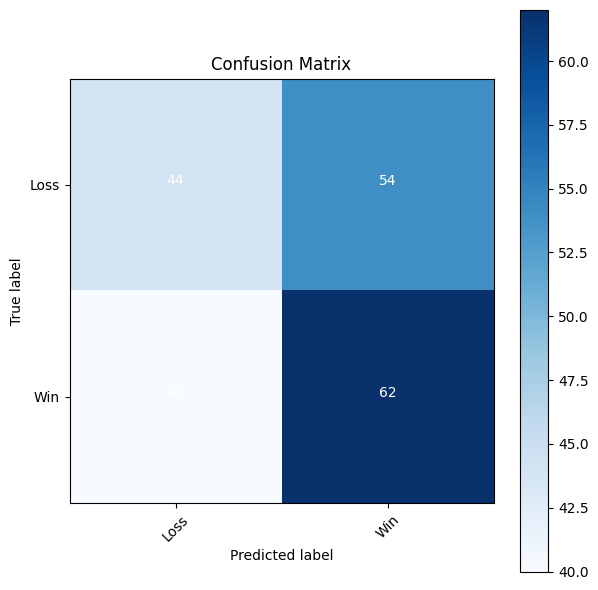

Classification Report:
               precision    recall  f1-score   support

        Loss       0.52      0.45      0.48        98
         Win       0.53      0.61      0.57       102

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.53      0.53       200



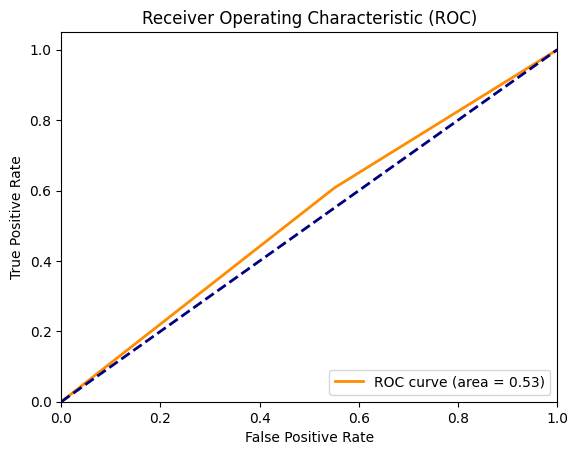

In [6]:
# Visualize the confusion matrix
cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Loss', 'Win'], rotation=45)
plt.yticks(tick_marks, ['Loss', 'Win'])

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_test, test_preds, target_names=['Loss', 'Win']))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


**Retraining with L2 regularization**

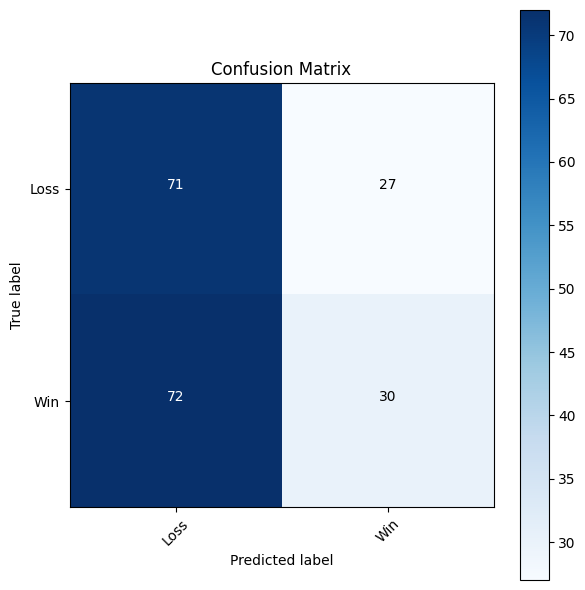

Classification Report:
               precision    recall  f1-score   support

        Loss       0.50      0.72      0.59        98
         Win       0.53      0.29      0.38       102

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.48       200
weighted avg       0.51      0.51      0.48       200



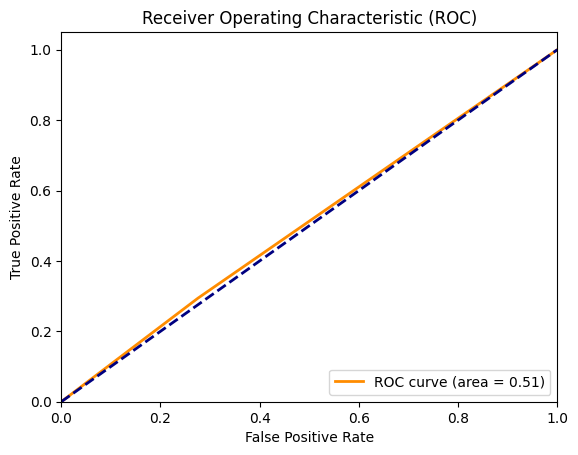

In [7]:
# Visualize the confusion matrix
cm = confusion_matrix(y_test, test_preds_l2)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Loss', 'Win'], rotation=45)
plt.yticks(tick_marks, ['Loss', 'Win'])

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_test, test_preds_l2, target_names=['Loss', 'Win']))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_preds_l2)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## 7) Save and load model

Save trained model to file (`model.pth`), load it back into a new model instance, and re-evaluate to confirm identical performance.

In [8]:
# Save the model
torch.save(model.state_dict(), 'model.pth')

# Load the model
model = LogisticRegressionModel(input_dim = X_train.shape[1], output_dim = 1)
model.load_state_dict(torch.load('model.pth'))

# Ensure the loaded model is in evaluation mode
model.eval()

# Evaluate the loaded model
with torch.no_grad():
    train_outputs = model(X_train)
    test_outputs = model(X_test)

    train_preds = (train_outputs >= 0.5).float()
    test_preds = (test_outputs >= 0.5).float()

    y_train_reshaped = y_train.view(-1, 1)
    y_test_reshaped = y_test.view(-1, 1)

    train_accuracy = (train_preds.eq(y_train_reshaped).sum().item()) / y_train_reshaped.size(0)
    test_accuracy = (test_preds.eq(y_test_reshaped).sum().item()) / y_test_reshaped.size(0)

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.5300
Test Accuracy: 0.5300


## 8) Hyperparameter Tuning 

Train a fresh logistic regression model for a set of candidate learning rates, evaluate test accuracy for each, and select the best learning rate based on test performance.

In [9]:
lrs = [0.01, 0.05, 0.1]
epochs = 100

best_lr = None
best_accuracy = 0.0

for lr in lrs:
    print(f"\nEntrenando con learning rate: {lr}")

    model = LogisticRegressionModel(input_dim=X_train.shape[1], output_dim=1)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train.view(-1, 1))
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_preds = (test_outputs >= 0.5).float()
        
        test_accuracy = (test_preds.eq(y_test.view(-1, 1)).sum().item()) / y_test.size(0)
        
        print(f"Learning rate {lr} - Test Accuracy: {test_accuracy:.4f}")

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_lr = lr

print(f"\nEl mejor learning rate es {best_lr} con una precisión de {best_accuracy:.4f}")



Entrenando con learning rate: 0.01
Learning rate 0.01 - Test Accuracy: 0.4200

Entrenando con learning rate: 0.05
Learning rate 0.05 - Test Accuracy: 0.5200

Entrenando con learning rate: 0.1
Learning rate 0.1 - Test Accuracy: 0.5250

El mejor learning rate es 0.1 con una precisión de 0.5250


## 9) Feature importance

Extract linear layer weights, build a DataFrame mapping feature names to weights (importance), sort and plot feature importances as a bar chart.

        Feature  Importance
5  wards_placed    0.049890
0         kills    0.035625
3   gold_earned    0.028598
2       assists    0.024626
6  wards_killed    0.023691
4            cs    0.010120
1        deaths    0.009900
7  damage_dealt   -0.105354


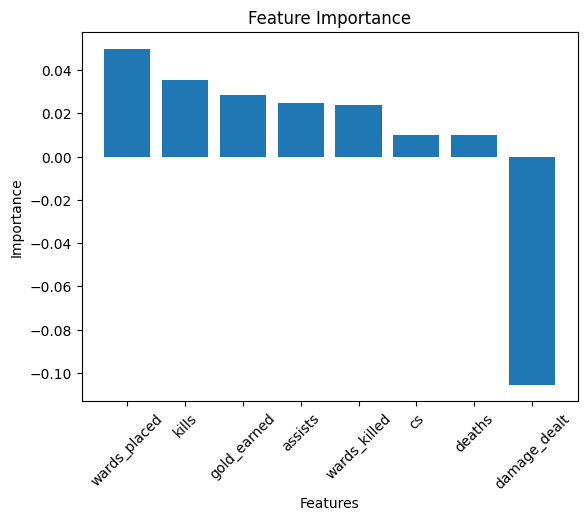

In [10]:
# Extract the weights of the linear layer:
weights = model.linear.weight.data.numpy().flatten()
features = X.columns

# Create a DataFrame for feature importance:
feature_importance = pd.DataFrame({'Feature': features, 'Importance': weights})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# Plot feature importance plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()

## 10) Notes & reproducibility

- Ensure `league_of_legends_data_large.csv` is accessible in the working directory.  
- The notebook trains multiple models and runs a learning-rate sweep — this can be time-consuming on CPU. Consider reducing epochs or sample sizes for quick testing.  


© Copyright IBM Corporation. All rights reserved.
